In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# Where to save figures/tables
os.makedirs("../figs/compare", exist_ok=True)
os.makedirs("../tables", exist_ok=True)

# Candidate cleaned CSV paths (the loader picks the first that exists)
CANDIDATES = {
    "Benin": ["../data/benin_clean.csv", "data/benin_clean.csv"],
    "Sierra Leone": ["../data/sierraleone_clean.csv", "../data/sierra_leone_clean.csv", "data/sierraleone_clean.csv", "data/sierra_leone_clean.csv"],
    "Togo": ["../data/togo_clean.csv", "data/togo_clean.csv"],
}

METRICS = ["GHI", "DNI", "DHI"]
PLOT_SAMPLE_PER_COUNTRY = 200_000  

def find_existing(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return None

def load_cleaned(country, candidates):
    path = find_existing(candidates.get(country, []))
    if path is None:
        raise FileNotFoundError(f"Cleaned CSV not found for {country}. Checked: {candidates.get(country, [])}")
    df = pd.read_csv(path)
    # Standardize timestamp if present
    tcol = next((c for c in df.columns if "time" in c.lower() or "date" in c.lower()), None)
    if tcol:
        df = df.rename(columns={tcol: "Timestamp"})
        df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
    # Keep only needed columns
    keep = ["Timestamp", "clean_flag"] + [c for c in METRICS if c in df.columns]
    df = df[[c for c in keep if c in df.columns]].copy()
    df["Country"] = country
    # Ensure numeric
    for m in METRICS:
        if m in df:
            df[m] = pd.to_numeric(df[m], errors="coerce")
    return df, path

# Load all
dfs, paths = [], {}
for country in CANDIDATES:
    d, p = load_cleaned(country, CANDIDATES)
    dfs.append(d)
    paths[country] = p

df_all = pd.concat(dfs, ignore_index=True)
print("Loaded paths:", paths)
print("Shape (combined):", df_all.shape)

# Optional: restrict to overlapping time window across all countries (fairer comparison)
if "Timestamp" in df_all.columns and not df_all["Timestamp"].isna().all():
    time_min = df_all.groupby("Country")["Timestamp"].min().max()
    time_max = df_all.groupby("Country")["Timestamp"].max().min()
    if pd.notna(time_min) and pd.notna(time_max) and time_min < time_max:
        df_all = df_all[(df_all["Timestamp"] >= time_min) & (df_all["Timestamp"] <= time_max)]
        print(f"Aligned to overlapping window: {time_min} → {time_max}. New shape: {df_all.shape}")
    else:
        print("Could not determine a common overlapping window; proceeding with all available data.")
else:
    print("No Timestamp found; proceeding without time alignment.")

Loaded paths: {'Benin': '../data/benin_clean.csv', 'Sierra Leone': '../data/sierraleone_clean.csv', 'Togo': '../data/togo_clean.csv'}
Shape (combined): (1576800, 6)
Aligned to overlapping window: 2021-10-30 00:01:00 → 2022-10-25 00:00:00. New shape: (1555200, 6)


In [2]:
# Summary table (mean, median, std) for GHI, DNI, DHI
summary = (
    df_all
    .groupby("Country")[METRICS]
    .agg(["mean", "median", "std"])
    .round(2)
)
display(summary)

summary.to_csv("../tables/compare_summary_stats.csv")
print("Saved summary to ../tables/compare_summary_stats.csv")

GHI                    DNI                    DHI         \
                mean median     std    mean median     std    mean median   
Country                                                                     
Benin         382.92  359.4  217.34  174.99  115.3  193.41  228.48  224.7   
Sierra Leone  376.08  359.4  205.70  162.95  115.3  174.07  224.07  224.7   
Togo          442.07  430.3  228.20  148.47    0.0  247.72  112.51    1.8   

                      
                 std  
Country               
Benin         104.65  
Sierra Leone   96.68  
Togo          151.50

Saved summary to ../tables/compare_summary_stats.csv


C:\Users\haymi\AppData\Local\Temp\ipykernel_7376\99606771.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=plot_df, x="Country", y=m, palette="Set2")


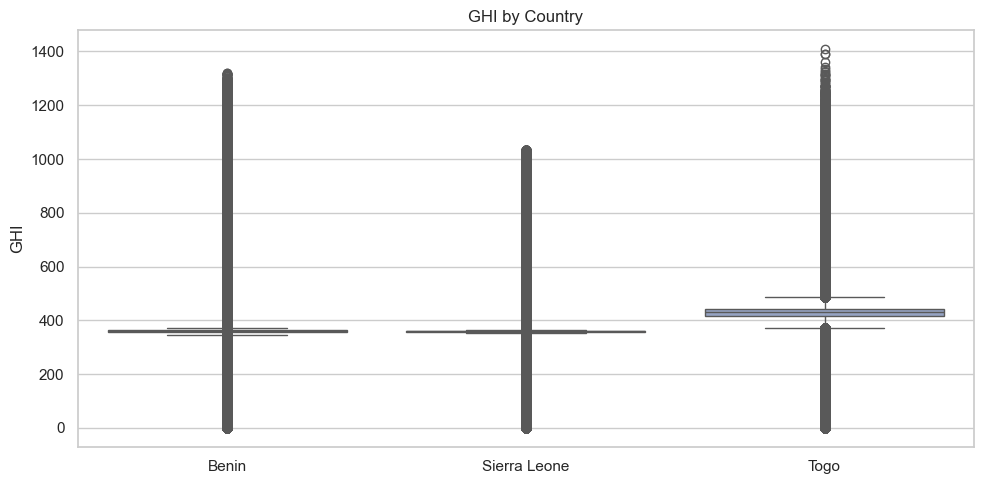

C:\Users\haymi\AppData\Local\Temp\ipykernel_7376\99606771.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=plot_df, x="Country", y=m, palette="Set2")


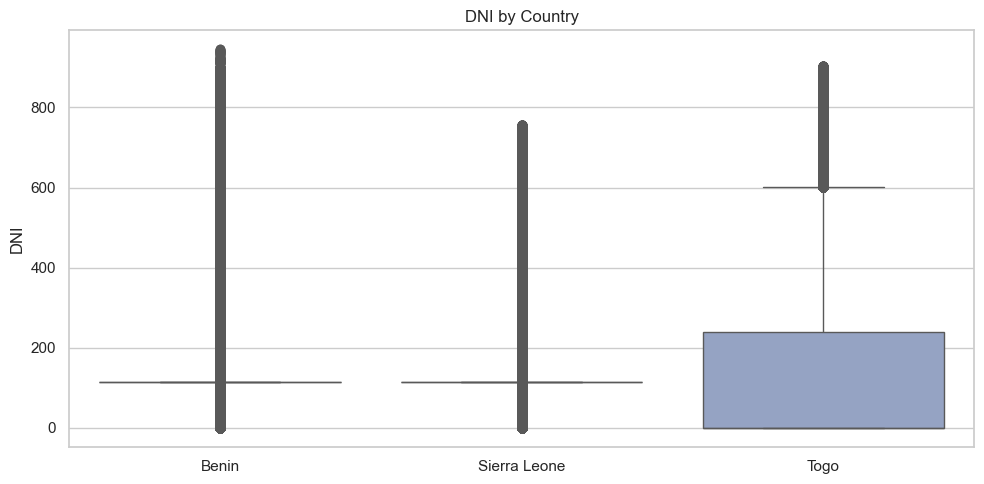

C:\Users\haymi\AppData\Local\Temp\ipykernel_7376\99606771.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=plot_df, x="Country", y=m, palette="Set2")


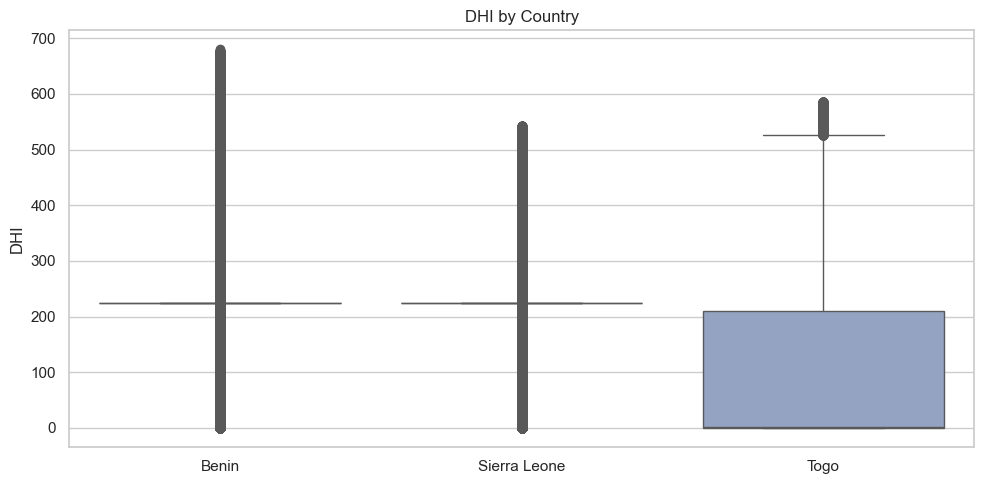

In [3]:
#Boxplots for each metric (one figure per metric, colored by country)

plot_df = df_all.copy()
for c in plot_df["Country"].unique():
    sub = plot_df[plot_df["Country"] == c]
    if len(sub) > PLOT_SAMPLE_PER_COUNTRY:
        plot_df = pd.concat([plot_df[plot_df["Country"] != c], sub.sample(PLOT_SAMPLE_PER_COUNTRY, random_state=42)])

for m in METRICS:
    if m not in plot_df.columns: 
        print(f"Skipping {m} (missing).")
        continue
    ax = sns.boxplot(data=plot_df, x="Country", y=m, palette="Set2")
    ax.set_title(f"{m} by Country")
    ax.set_xlabel("")
    plt.tight_layout()
    plt.savefig(f"../figs/compare/F_box_{m.lower()}_by_country.png", dpi=180)
    plt.show()

In [4]:
#Statistical testing on GHI (ANOVA + Kruskal–Wallis) and effect size


groups = []
labels = []
for c, g in df_all.groupby("Country"):
    if "GHI" in g.columns and not g["GHI"].dropna().empty:
        groups.append(g["GHI"].dropna().values)
        labels.append(c)

print("Countries in GHI test:", labels)

# ANOVA
anova = stats.f_oneway(*groups)
# Levene (homogeneity of variances)
levene = stats.levene(*groups, center="median")
# Kruskal–Wallis (non-parametric)
kruskal = stats.kruskal(*groups)

# Eta-squared (effect size) for one-way ANOVA
# eta^2 = SS_between / SS_total
all_vals = np.concatenate(groups)
grand_mean = np.mean(all_vals)
ss_total = np.sum((all_vals - grand_mean) ** 2)
ss_between = 0.0
for arr in groups:
    ss_between += len(arr) * (np.mean(arr) - grand_mean) ** 2
eta_sq = ss_between / ss_total if ss_total > 0 else np.nan

print(f"ANOVA: F={anova.statistic:.3f}, p={anova.pvalue:.3e}")
print(f"Levene (equal variances): W={levene.statistic:.3f}, p={levene.pvalue:.3e}")
print(f"Kruskal–Wallis: H={kruskal.statistic:.3f}, p={kruskal.pvalue:.3e}")
print(f"Effect size (eta^2): {eta_sq:.3f}")

# Quick interpretation hint
if anova.pvalue < 0.05 or kruskal.pvalue < 0.05:
    print("Interpretation: There is evidence of differences in GHI across countries.")
else:
    print("Interpretation: No strong evidence of differences in GHI across countries.")


Countries in GHI test: ['Benin', 'Sierra Leone', 'Togo']
ANOVA: F=14457.890, p=0.000e+00
Levene (equal variances): W=1682.305, p=0.000e+00
Kruskal–Wallis: H=123327.419, p=0.000e+00
Effect size (eta^2): 0.018
Interpretation: There is evidence of differences in GHI across countries.


C:\Users\haymi\AppData\Local\Temp\ipykernel_7376\1675428013.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rank_df, x="Country", y="Avg_GHI", palette="viridis")


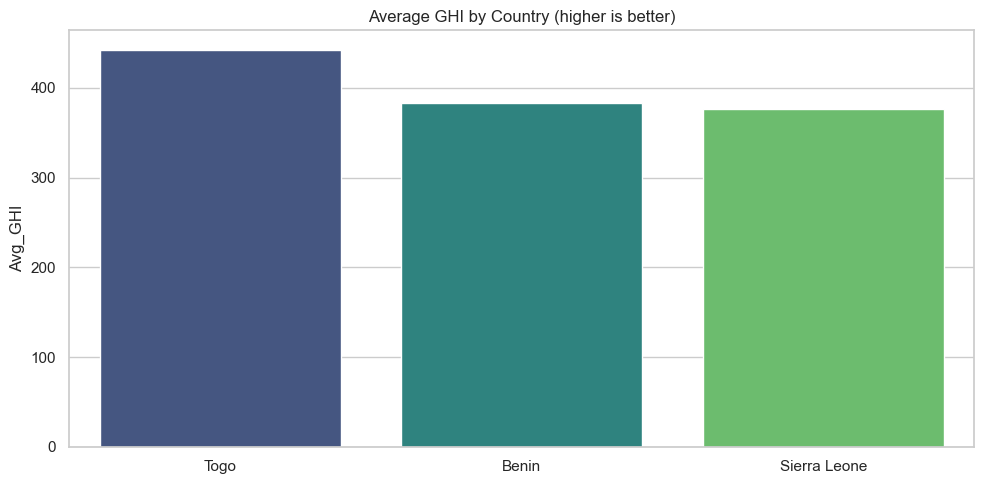

,Country,Avg_GHI
0,Togo,442.07
1,Benin,382.92
2,Sierra Leone,376.08


In [5]:
# Visual summary: ranking bar (average GHI by country)
rank_df = (
    df_all
    .groupby("Country")["GHI"]
    .mean()
    .sort_values(ascending=False)
    .round(2)
    .reset_index(name="Avg_GHI")
)

sns.barplot(data=rank_df, x="Country", y="Avg_GHI", palette="viridis")
plt.title("Average GHI by Country (higher is better)")
plt.xlabel("")
plt.tight_layout()
plt.savefig("../figs/compare/F_bar_rank_mean_ghi.png", dpi=180)
plt.show()

rank_df


In [6]:
#Auto-generate 3 key observations

obs = []

# 1) Highest/lowest mean GHI
top = rank_df.iloc[0]
bot = rank_df.iloc[-1]
obs.append(f"{top['Country']} shows the highest average GHI ({top['Avg_GHI']}). {bot['Country']} is lowest ({bot['Avg_GHI']}).")

# 2) Variability from summary std
stds = summary.xs("std", axis=1, level=1)["GHI"].sort_values(ascending=False)
obs.append(f"Variability (GHI std) is highest in {stds.index[0]} and lowest in {stds.index[-1]}.")

# 3) Statistical test outcome
sig_note = "significant" if (anova.pvalue < 0.05 or kruskal.pvalue < 0.05) else "not statistically significant"
obs.append(f"Cross-country GHI differences are {sig_note} at the 5% level (ANOVA p={anova.pvalue:.2e}, Kruskal p={kruskal.pvalue:.2e}; eta²={eta_sq:.2f}).")

print("Key observations to paste in Markdown:")
for i, o in enumerate(obs, 1):
    print(f"- {o}")

Key observations to paste in Markdown:
- Togo shows the highest average GHI (442.07). Sierra Leone is lowest (376.08).
- Variability (GHI std) is highest in Togo and lowest in Sierra Leone.
- Cross-country GHI differences are significant at the 5% level (ANOVA p=0.00e+00, Kruskal p=0.00e+00; eta²=0.02).
